In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk import ngrams
nltk.download('punkt_tab')
from wordcloud import STOPWORDS as stopwords
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hades\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# ruta ds Amazon Movies and TV
ruta_ds = "Movies_and_TV_5.json"

reviews = []
with open(ruta_ds, "r") as f:
    for line in f:
        reviews.append(json.loads(line))
df = pd.DataFrame(reviews)
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [3]:
# Análisis exploratorio
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697533 entries, 0 to 1697532
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   reviewerName    object 
 3   helpful         object 
 4   reviewText      object 
 5   overall         float64
 6   summary         object 
 7   unixReviewTime  int64  
 8   reviewTime      object 
dtypes: float64(1), int64(1), object(7)
memory usage: 116.6+ MB


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
count,1697533,1697533,1691457,1697533,1697533,1.697533e+06,1697533,1.697533e+06,1697533
unique,123960,50052,112400,9013,1696352,NaN,1296940,NaN,5799
top,A3LZGLA88K0LA0,B003EYVXV4,Amazon Customer,"[0, 0]",,NaN,Great Movie,NaN,"01 28, 2014"
freq,2368,2213,11777,608781,62,NaN,4640,NaN,2322
mean,NaN,NaN,NaN,NaN,NaN,4.110648e+00,NaN,1.262422e+09,NaN
std,NaN,NaN,NaN,NaN,NaN,1.197615e+00,NaN,1.289277e+08,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,8.793792e+08,NaN
25%,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,1.164413e+09,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,1.307491e+09,NaN
75%,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,1.373242e+09,NaN


C:\Users\hades\AppData\Local\Temp\ipykernel_26540\3615199977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["overall"], palette="viridis")


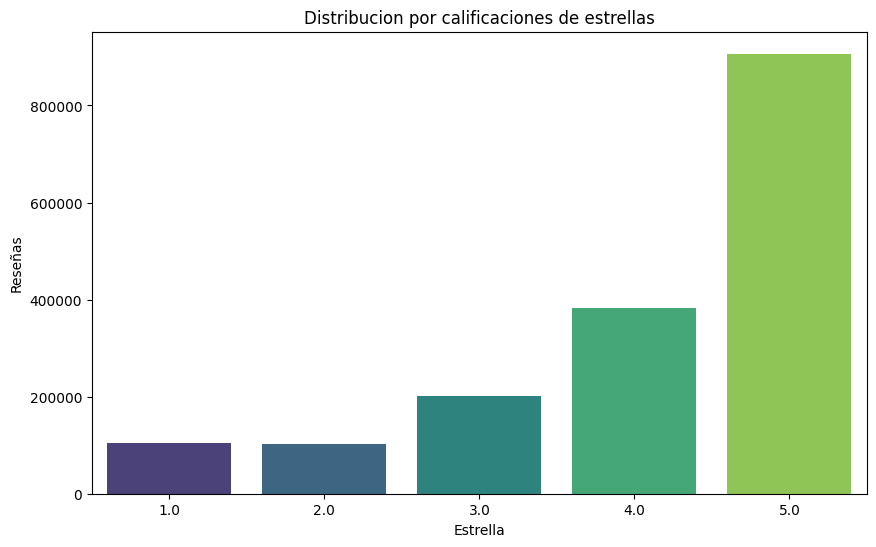

In [4]:
# Calificaciones de estrellas
plt.figure(figsize=(10,6))
sns.countplot(x=df["overall"], palette="viridis")
plt.title('Distribucion por calificaciones de estrellas')
plt.xlabel('Estrella')
plt.ylabel('Reseñas')
plt.show()

C:\Users\hades\AppData\Local\Temp\ipykernel_26540\131359342.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_limpio["sentiment"], palette="Set2")


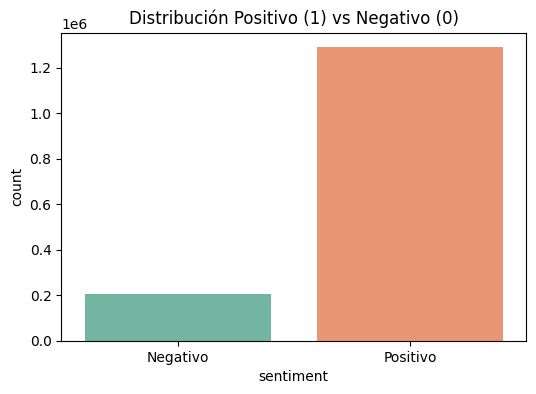

sentiment
1    1289602
0     206629
Name: count, dtype: int64

In [5]:
# Obtener sentimiento positivo y negativo, se elimina la calificación neutral (3 estrellas)
df_limpio = df[df["overall"] != 3].copy()
df_limpio["sentiment"] = df_limpio["overall"].apply(lambda x: 1 if x > 3 else 0)
#Sentimientos
plt.figure(figsize=(6,4))
sns.countplot(x=df_limpio["sentiment"], palette="Set2")
plt.title("Distribución Positivo (1) vs Negativo (0)")
plt.xticks([0,1], ["Negativo", "Positivo"])
plt.show()

df_limpio["sentiment"].value_counts()


In [6]:
# Vocabulario y tokenizacion
tokens = " ".join(df["reviewText"].astype(str)).split()
vocabulario = set(tokens)
print(f"Tamaño del vocabulario: {len(vocabulario)}")
print(f"Número total de tokens: {len(tokens)}")

Tamaño del vocabulario: 5185217
Número total de tokens: 274245314


In [7]:
# se extraen bigramas y trigramas
texto_ejempl = df["reviewText"].astype(str).sample(20000, random_state=42)

bigrams_ = Counter()
trigram_ = Counter()

for texto_review in texto_ejempl:
    tokens = nltk.word_tokenize(texto_review.lower())
    bigrams_.update(ngrams(tokens, 2))
    trigram_.update(ngrams(tokens, 3))
# Mostrar 10 bigramas comunes
print("Top 10 bigrams:")
bigrams_.most_common(10)


Top 10 bigrams:


[(('of', 'the'), 22808),
 ((',', 'and'), 17303),
 (('.', 'the'), 13922),
 (('in', 'the'), 13091),
 (('.', 'i'), 11971),
 ((',', 'but'), 11677),
 ((',', 'the'), 8877),
 (('is', 'a'), 8873),
 (('it', "'s"), 8015),
 (('.', 'it'), 7940)]

In [8]:
# Mostrar 10 trigramas más comunes
print("Top 10 trigrams:")
trigram_.most_common(10)

Top 10 trigrams:


[(('&', 'quot', ';'), 3979),
 (('one', 'of', 'the'), 2622),
 (('.', 'it', "'s"), 2386),
 (('&', '#', '34'), 2353),
 (('#', '34', ';'), 2353),
 ((',', 'and', 'the'), 2020),
 (('this', 'is', 'a'), 2007),
 (('!', '!', '!'), 1803),
 (('.', 'it', 'is'), 1780),
 (('.', 'this', 'is'), 1722)]

In [9]:
# se crea el corpus  completo
texto_review = " ".join(df["reviewText"].astype(str))

In [10]:
# Se definen stopwords personalizadas
sw = set(stopwords)
sw.update(["movie", "film", "show", "one", "like", "take", "time", "see", "watch", "character", "story", "even", "get", "make", "really"])
wordc = WordCloud(width=1600, height=800, stopwords=sw, background_color="white").generate(texto_review)

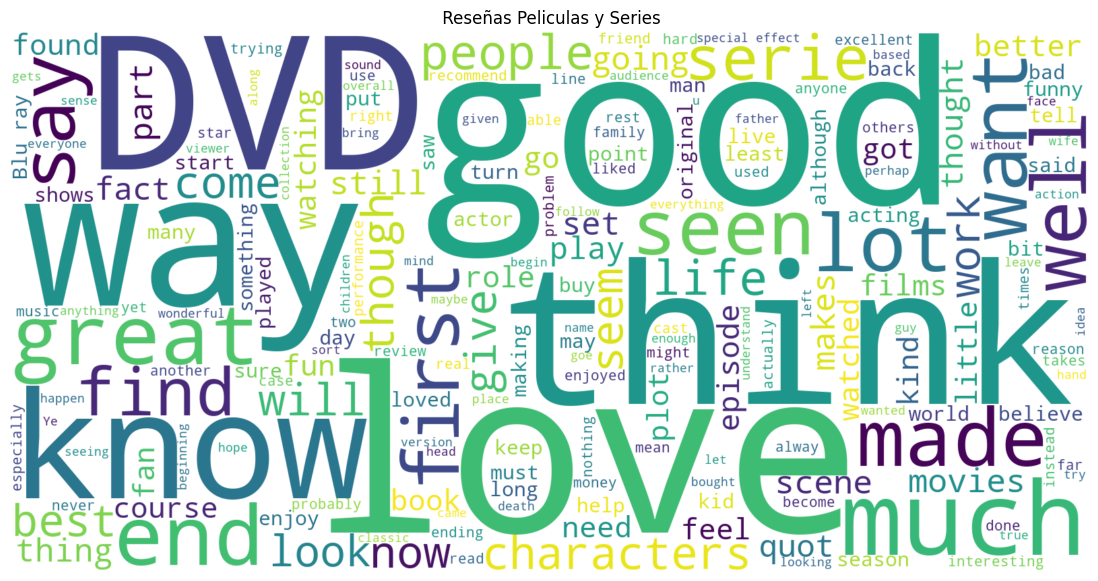

In [11]:

# Mostrar palatras importantes
plt.figure(figsize=(15,7))
plt.imshow(wordc, interpolation="bilinear")
plt.axis("off")
plt.title(" Reseñas Peliculas y Series")
plt.show()

In [12]:
# Se crea el corpus para Word2Vec
corpus = [nltk.word_tokenize(str(t).lower()) 
    for t in df["reviewText"].sample(50000, random_state=42)]


In [13]:
# Entrenamiento modelo Word2Vec
w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4)

modelo_w2v = w2v.wv
print(f"Tamaño del vocabulario Word2Vec: {len(modelo_w2v)}")


Tamaño del vocabulario Word2Vec: 37595


In [14]:
#  Set de palabras para similares
palabras =  ["movie", "story", "actor", "character", "love", "good", "bad", "time", "watch", "series"]
for p in palabras:
    if p in modelo_w2v:
        # Se muestra TOP  10 de palabras similares
        print(f"top 10 palabras similares a '{p}':")
        print(modelo_w2v.most_similar(p, topn=10))

top 10 palabras similares a 'movie':
[('film', 0.9087430834770203), ('flick', 0.7594974637031555), ('show', 0.6385288238525391), ('series', 0.6311454772949219), ('it', 0.610706627368927), ('sequel', 0.6051191091537476), ('anime', 0.6025508046150208), ('storyline', 0.5889540910720825), ('movies', 0.57499760389328), ('thriller', 0.5621108412742615)]
top 10 palabras similares a 'story':
[('storyline', 0.8136436343193054), ('plot', 0.7719174027442932), ('tale', 0.6979390382766724), ('premise', 0.6796255707740784), ('stories', 0.6401359438896179), ('script', 0.6320325136184692), ('concept', 0.6211491227149963), ('plotline', 0.5723739266395569), ('narrative', 0.541437566280365), ('movie', 0.5371338725090027)]
top 10 palabras similares a 'actor':
[('actress', 0.7386472821235657), ('role', 0.6861169934272766), ('artist', 0.6723529100418091), ('villain', 0.6464524269104004), ('comedian', 0.6414545774459839), ('performance', 0.6131092309951782), ('performer', 0.6105536222457886), ('singer', 0.60

Tamaño del vocabulario Word2Vec: 37595
Reduciendo dimensionalidad con t-SNE...


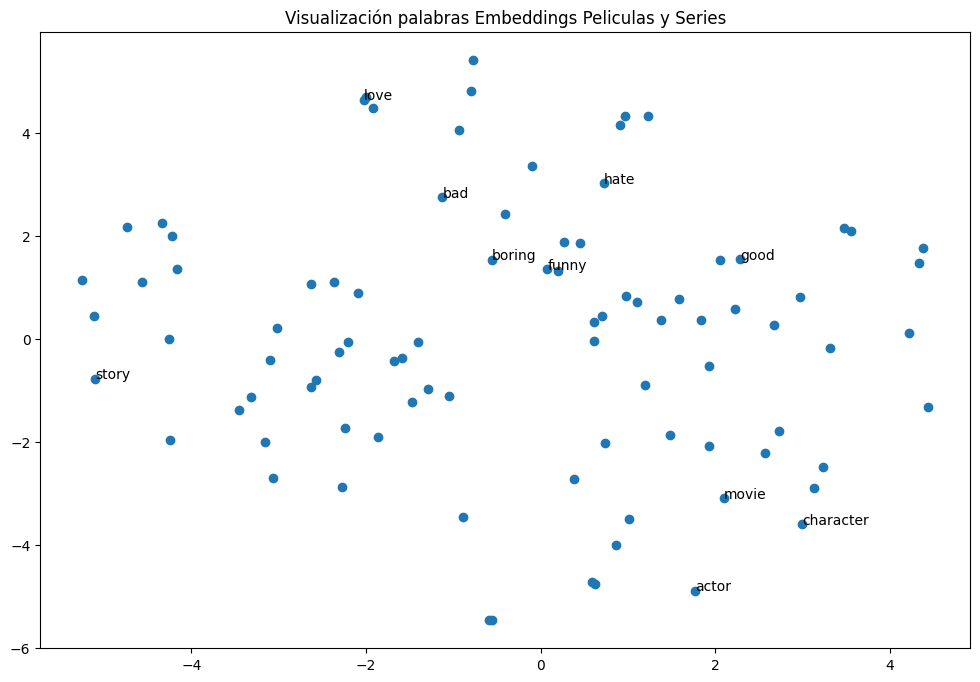

In [15]:
# set de palabras para visualizar
palabras = ["movie", "actor", "story", "character", "love", "hate", "good", "bad", "funny", "boring"]
ps = []

for p in palabras:
    if p in modelo_w2v:
        ps.extend([p] + [sw for sw,_ in modelo_w2v.most_similar(p, topn=10)])
unicas = list(set(ps))

vector = np.array([modelo_w2v[u] for u in unicas])
# MOstrar tamaño del vocabulario Word2Vec
print(f"Tamaño del vocabulario Word2Vec: {len(modelo_w2v)}")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
print("Reduciendo dimensionalidad con t-SNE...")
minimisa =  tsne.fit_transform(vector)

plt.figure(figsize=(12,8))
plt.scatter(minimisa[:,0], minimisa[:,1])

for i, word in enumerate(palabras):
    plt.annotate(word, xy=(minimisa[i,0], minimisa[i,1]))
#mostrar grafdico con distribución de recurrencia entre  palabras
plt.title("Visualización palabras Embeddings Peliculas y Series")
plt.show()
